In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid

In [3]:
import sys
sys.path.append('../src/training-on-CM2.6/')
from helpers.train_rho_fluxes import *
from helpers.cm26 import read_datasets
from helpers.selectors import *

# Training section.

In [5]:
ann_instance, logger = train_ANN_rho_fluxes(factors=[4, 12], 
                                    time_iters=200, 
                                    depth_idx=np.arange(0, 50,10))

Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-12
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-12
Factor: 12, depth: 10, MSE train/validate: [2.908353, 2.675088]
Factor: 4, depth: 10, MSE train/validate: [3.621286, 3.882504]
Factor: 12, depth: 0, MSE train/validate: [2.708737, 2.370206]
Factor: 4, depth: 30, MSE train/validate: [5.240472, 4.396167]
Factor: 4, depth: 0, MSE train/validate: [2.970069, 2.239447]
Factor: 12, depth: 30, MSE train/validate: [2.436960, 2.271054]
Factor: 4, depth: 20, MSE train/validate: [4.055432, 4.109380]
Factor: 12, depth: 40, MSE train/validate: [1.616795, 1.747982]
Factor: 4, depth: 40, MSE train/validate: [2.456254, 2.307108]
Factor: 12, depth: 20, MSE train/validate: [2.402484, 2.211318]
Iter/num_iters [1/200]. Iter time/Remaining time in s

In [8]:
nfeatures = ann_instance.layer_sizes[0]
print(nfeatures)

45


In [9]:
from helpers.ann_tools import export_ANN
nfeatures = ann_instance.layer_sizes[0]
export_ANN(ann_instance, input_norms=torch.ones(nfeatures), output_norms=torch.ones(2), 
                filename='ann_instance_6Nov.nc')

logger.to_netcdf('logger_6Nov.nc')

In [11]:
logger

<xarray.Dataset> Size: 32kB
Dimensions:       (factor: 2, depth: 5, iter: 200)
Coordinates:
  * factor        (factor) int64 16B 4 12
  * depth         (depth) int64 40B 0 10 20 30 40
Dimensions without coordinates: iter
Data variables:
    MSE_train     (iter, factor, depth) float64 16kB 2.97 3.621 ... 0.3479 0.583
    MSE_validate  (iter, factor, depth) float64 16kB 2.239 3.883 ... 0.5667

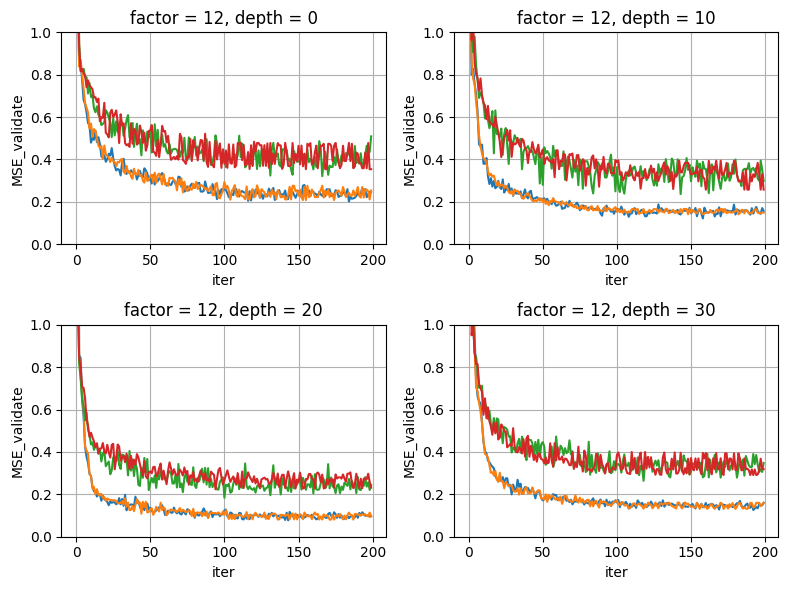

In [17]:
plt.figure(figsize=(8,6))

def plot_MSE(logger, factor_id, depth_idx):
    logger['MSE_train'].isel(factor=factor_id, depth=depth_idx).plot()
    logger['MSE_validate'].isel(factor=factor_id, depth=depth_idx).plot()

plt.subplot(2,2,1)
plot_MSE(logger, factor_id=0, depth_idx=0)
plot_MSE(logger, factor_id=1, depth_idx=0)
plt.ylim([0,1])
plt.grid()

plt.subplot(2,2,2)
id_depth = 1
plot_MSE(logger, factor_id=0, depth_idx=id_depth)
plot_MSE(logger, factor_id=1, depth_idx=id_depth)
plt.ylim([0,1])
plt.grid()

plt.subplot(2,2,3)
id_depth = 2
plot_MSE(logger, factor_id=0, depth_idx=id_depth)
plot_MSE(logger, factor_id=1, depth_idx=id_depth)
plt.ylim([0,1])
plt.grid()

plt.subplot(2,2,4)
id_depth = 3
plot_MSE(logger, factor_id=0, depth_idx=id_depth)
plot_MSE(logger, factor_id=1, depth_idx=id_depth)
plt.ylim([0,1])
plt.grid()

plt.tight_layout()

# Checking predictions

In [4]:
from helpers.ann_tools import import_ANN
ann_instance = import_ANN('ann_instance_6Nov.nc')

In [23]:
ds = read_datasets(factors=[4, 9, 12])

Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-4
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-9
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-9
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-9
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-12
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-12
Reading from folder /vast/db194/CM26_datasets/ocean3d/subfilter/FGR3/factor-12


In [24]:
ds

{'train-4': <helpers.cm26.DatasetCM26 at 0x7f14b1f98950>,
 'test-4': <helpers.cm26.DatasetCM26 at 0x7f1449bfc9d0>,
 'validate-4': <helpers.cm26.DatasetCM26 at 0x7f14cd9cb2d0>,
 'train-9': <helpers.cm26.DatasetCM26 at 0x7f143a2267d0>,
 'test-9': <helpers.cm26.DatasetCM26 at 0x7f1405da0610>,
 'validate-9': <helpers.cm26.DatasetCM26 at 0x7f13e361db10>,
 'train-12': <helpers.cm26.DatasetCM26 at 0x7f13deb3ced0>,
 'test-12': <helpers.cm26.DatasetCM26 at 0x7f13d4974750>,
 'validate-12': <helpers.cm26.DatasetCM26 at 0x7f13c853f110>}

In [25]:
dds = ds['test-9'].select2d(zl=20)
prediction = dds.state.ANN_rho_inference(ann_instance, return_xarray=True)

Correlation: 0.9145532250404358
Relative Error: 0.4888218641281128
R2 =  0.8363449275493622
R2 max =  0.8363833278417587
Optinal scaling: 1.006822943687439
Nans [test/control]: [4097, 4097]


array([[<Axes: title={'center': 'Tested field'}, xlabel='xh', ylabel='yh'>,
        <Axes: title={'center': 'Control field'}, xlabel='xh', ylabel='yh'>],
       [<Axes: title={'center': 'Tested field $-$ Control field'}, xlabel='xh', ylabel='yh'>,
        <Axes: >]], dtype=object)

<Figure size 800x700 with 0 Axes>

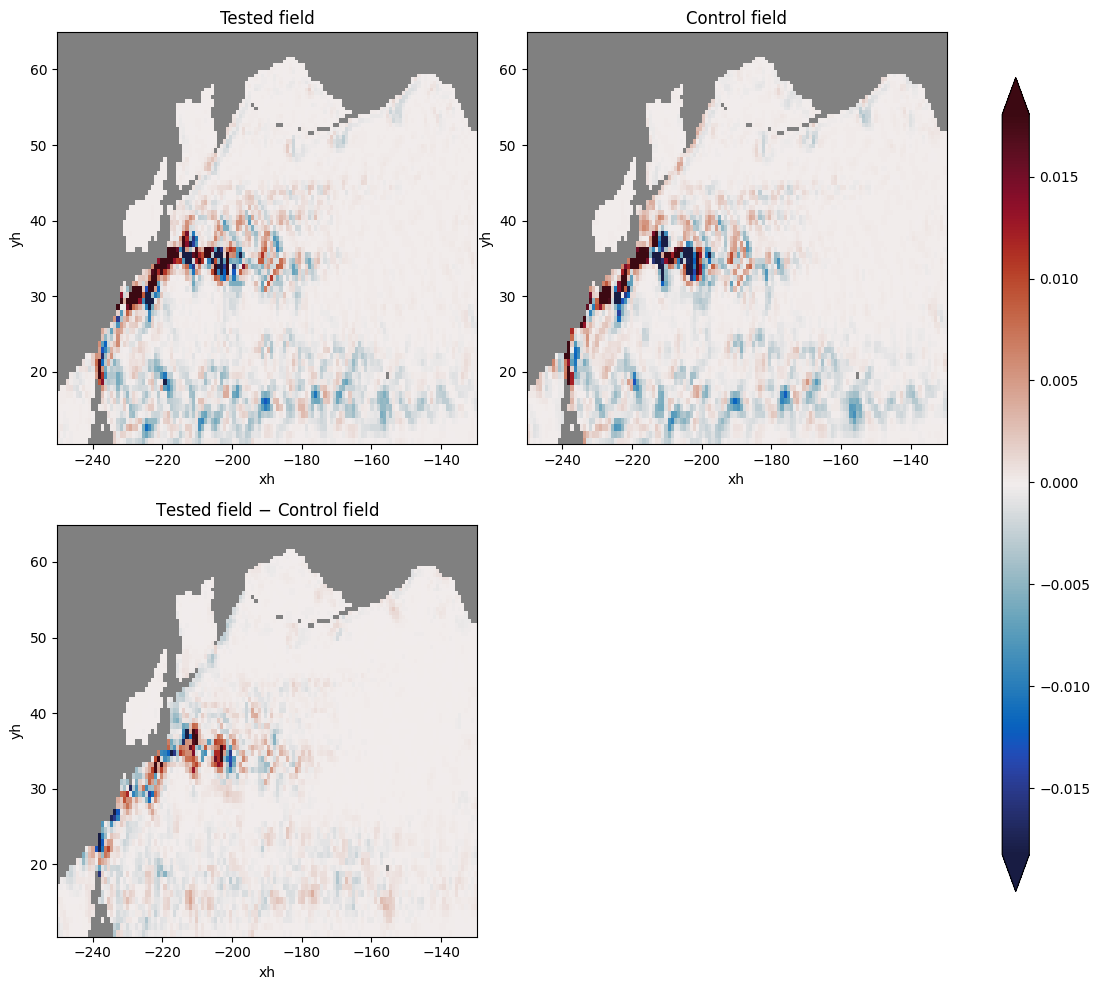

In [26]:
plt.figure(figsize=(8,7))
compare(dds.nanvar(prediction['Fy_xarray'],0), dds.nanvar(dds.data.Fy,0), selector=select_Pacific)

Correlation: 0.8115416765213013
Relative Error: 0.6037068367004395
R2 =  0.6578910946846008
R2 max =  0.6578914225101471
Optinal scaling: 1.0007061958312988
Nans [test/control]: [2406, 2406]


array([[<Axes: title={'center': 'Tested field'}, xlabel='xh', ylabel='yh'>,
        <Axes: title={'center': 'Control field'}, xlabel='xh', ylabel='yh'>],
       [<Axes: title={'center': 'Tested field $-$ Control field'}, xlabel='xh', ylabel='yh'>,
        <Axes: >]], dtype=object)

<Figure size 800x700 with 0 Axes>

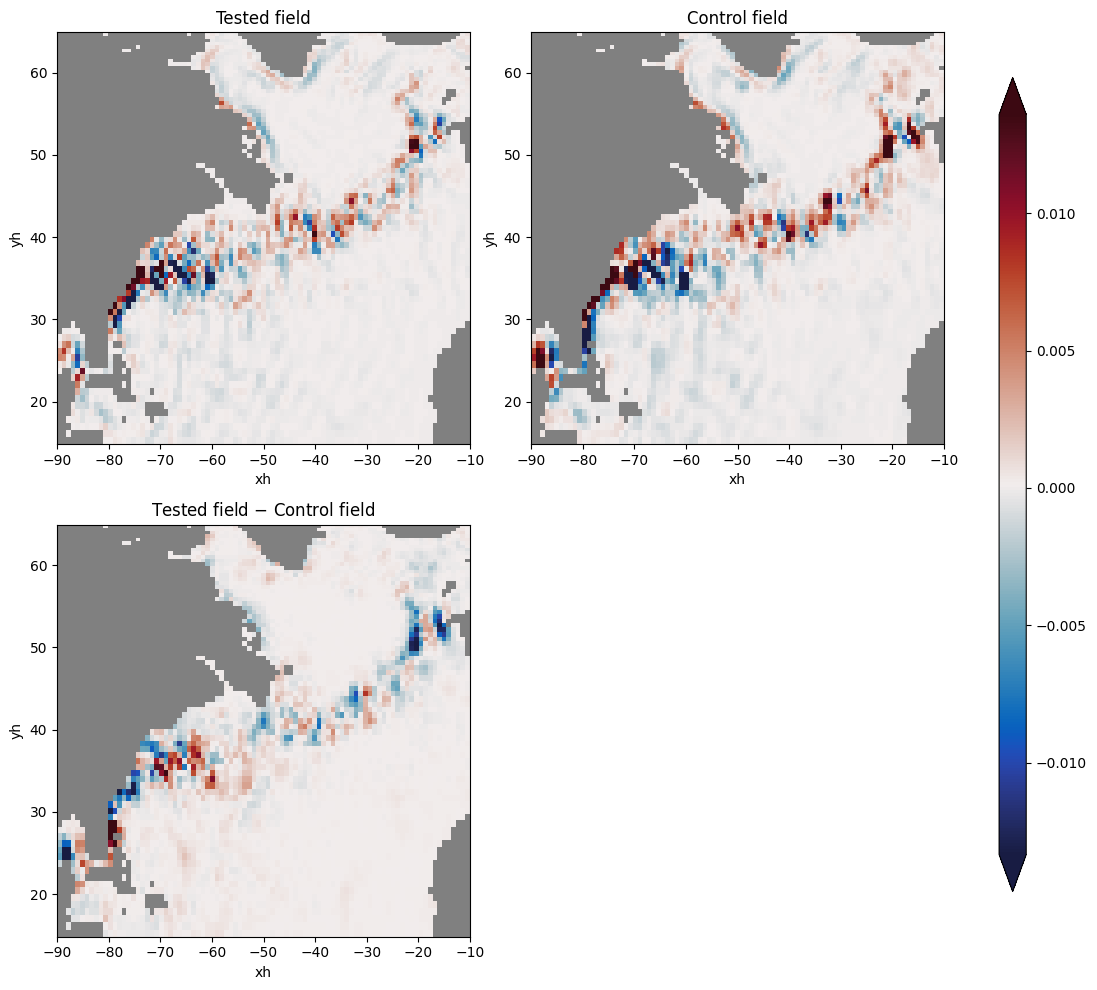

In [27]:
plt.figure(figsize=(8,7))
compare(dds.nanvar(prediction['Fy_xarray'],0), dds.nanvar(dds.data.Fy,0), 
selector=select_NA)

Correlation: 0.8968138694763184
Relative Error: 0.44962093234062195
R2 =  0.8001277148723602
R2 max =  0.8029224127531052
Optinal scaling: 1.0626955032348633
Nans [test/control]: [508, 508]


array([[<Axes: title={'center': 'Tested field'}, xlabel='xh', ylabel='yh'>,
        <Axes: title={'center': 'Control field'}, xlabel='xh', ylabel='yh'>],
       [<Axes: title={'center': 'Tested field $-$ Control field'}, xlabel='xh', ylabel='yh'>,
        <Axes: >]], dtype=object)

<Figure size 800x700 with 0 Axes>

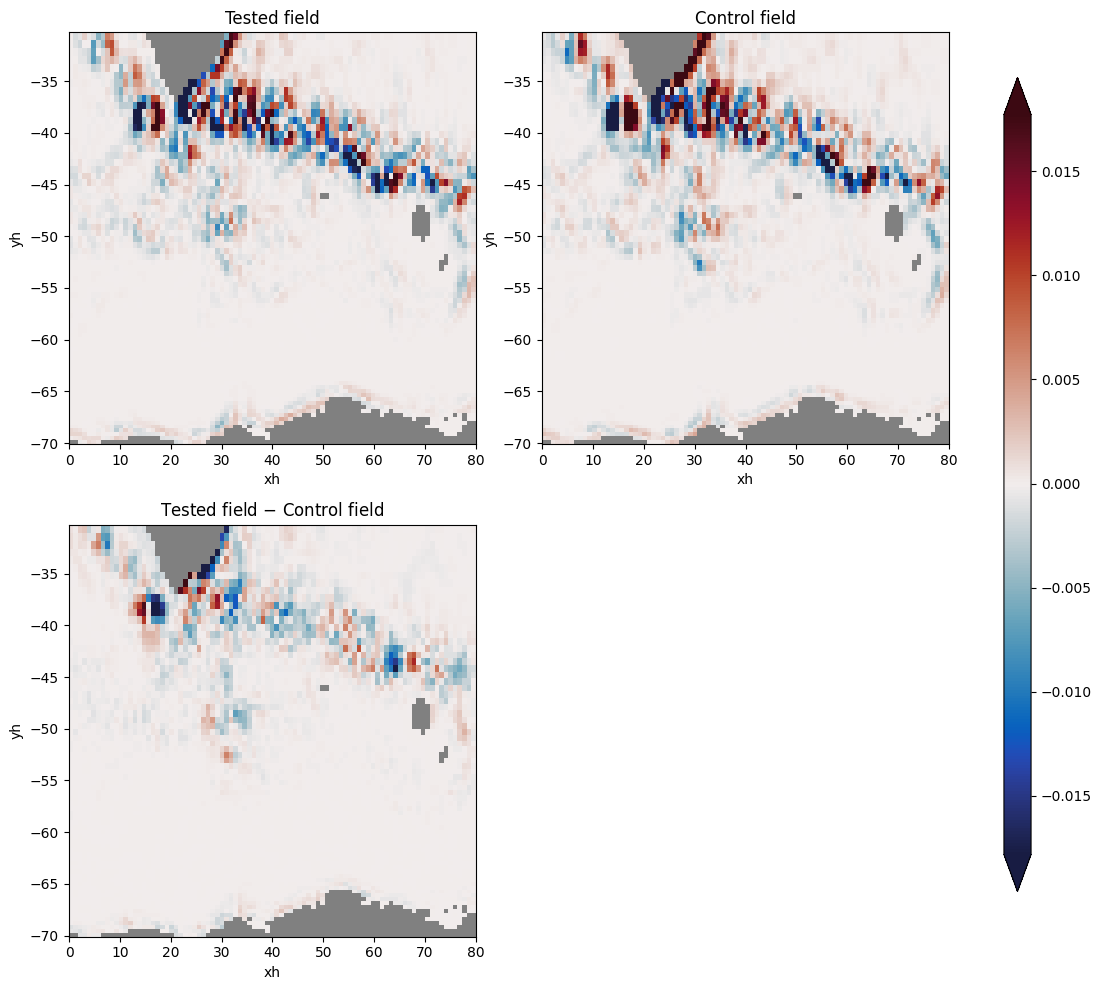

In [28]:
plt.figure(figsize=(8,7))
compare(dds.nanvar(prediction['Fy_xarray'],0), dds.nanvar(dds.data.Fy,0), 
selector=select_SO)